In [6]:
# This code uses the traditional measure of features importance, i.e. the increase in validation error by removing each feature

import os
import pickle
import numpy as np
import xgboost as xgb
import pandas as pd
from calculate_confusion_matrix import calculate_confusion_matrix

save_results = True

ft_dir = 'features_long/'

# list feature files
files = os.listdir(ft_dir)

with open('top_locations.dat') as f:
    state_top10 = pickle.load(f)
f.close()
# for (i,s) in enumerate(state_top10):
#     state_top10[i] = state_top10[i].replace('"','')
#     state_top10[i] = state_top10[i].replace('[','')
#     state_top10[i] = state_top10[i].replace(']','')

feature_all = []
state_all = []
state_fsq_all = []
for filename in files:
    with open(ft_dir+filename) as f:  
        feature, state = pickle.load(f)
        
        # only keeping top 10 states
        ind = np.array([], int)
        for (i,st) in enumerate(state['location']):
            if st in state_top10:
                ind = np.append(ind, i)
        feature = feature.loc[ind,:]
        state = state.loc[ind,'location']
        
        feature = feature.reset_index(drop = True)
        state = state.reset_index(drop = True)
        
        feature_all.append(feature)
        state_all.append(state)
        
    f.close()

n_fold = 10
n = len(feature_all)
fold_size= n/float(n_fold)
    

# reference AUC
auc_ref = np.zeros([n_fold])
for k in range(n_fold):

    ind_test = np.arange(np.ceil(k*fold_size), min(np.ceil((k+1)*fold_size),n)).astype(int)
    ind_train = np.delete(np.arange(n), ind_test)

    x_train = pd.concat([feature_all[j] for j in ind_train], axis=0)
    y_train = pd.concat([state_all[j] for j in ind_train], axis=0)
    x_test = pd.concat([feature_all[j] for j in ind_test], axis=0)
    y_test = pd.concat([state_all[j] for j in ind_test], axis=0)

    x_train = x_train.reset_index(drop = True)
    y_train = y_train.reset_index(drop = True)
    x_test = x_test.reset_index(drop = True)
    y_test = y_test.reset_index(drop = True)

    gbm = xgb.XGBClassifier(max_depth=6, n_estimators=75, learning_rate=0.05, nthread=12, subsample=0.25, \
                        colsample_bytree=0.2, max_delta_step=0, gamma=3, objective='mlogloss', reg_alpha=0.5, \
                        missing=np.nan, seed=0)
    gbm.fit(x_train, y_train)
    y_pred = gbm.predict(x_test)
    conf, roc_auc = calculate_confusion_matrix(y_pred, y_test)
    auc_ref[k] = np.nanmean(roc_auc)

# auc_ref = np.nanmean(auc_fold)
    
# removing features one at each time
delta_auc_mean = np.zeros([feature.shape[1]])
delta_auc_lo = np.zeros([feature.shape[1]])
delta_auc_hi = np.zeros([feature.shape[1]])
for (i,ft) in enumerate(feature.columns):
    print i,
    auc_fold = np.zeros([n_fold])
    for k in range(n_fold):

        ind_test = np.arange(np.ceil(k*fold_size), min(np.ceil((k+1)*fold_size),n)).astype(int)
        ind_train = np.delete(np.arange(n), ind_test)

        x_train = pd.concat([feature_all[j] for j in ind_train], axis=0)
        y_train = pd.concat([state_all[j] for j in ind_train], axis=0)
        x_test = pd.concat([feature_all[j] for j in ind_test], axis=0)
        y_test = pd.concat([state_all[j] for j in ind_test], axis=0)

        x_train = x_train.reset_index(drop = True)
        y_train = y_train.reset_index(drop = True)
        x_test = x_test.reset_index(drop = True)
        y_test = y_test.reset_index(drop = True)
        
        x_train = x_train.drop([ft], axis=1)
        x_test = x_test.drop([ft], axis=1)
        
        gbm = xgb.XGBClassifier(max_depth=6, n_estimators=75, learning_rate=0.05, nthread=12, subsample=0.25, \
                            colsample_bytree=0.2, max_delta_step=0, gamma=3, objective='mlogloss', reg_alpha=0.5, \
                            missing=np.nan, seed=0)
        gbm.fit(x_train, y_train)
        y_pred = gbm.predict(x_test)
        conf, roc_auc = calculate_confusion_matrix(y_pred, y_test)
        auc_fold[k] = np.nanmean(roc_auc)
        
    delta_auc_mean[i] = np.nanmean(auc_ref-auc_fold)
    delta_auc_lo[i] = np.nanmin(auc_ref-auc_fold)
    delta_auc_hi[i] = np.nanmax(auc_ref-auc_fold)
    print delta_auc_mean[i], delta_auc_lo[i], delta_auc_hi[i]


 0 -0.00838203049913 -0.0430688909773 0.0304861189836
1 0.00238658704419 -0.0386506240939 0.03500934061
2 -0.00628406521157 -0.0467917521437 0.040235493431
3 -0.00420516509649 -0.0458848793822 0.037485873259
4 -0.00817155501276 -0.0458599096394 0.0474776782274
5 8.31376500432e-05 -0.040691323577 0.0357288670481
6 0.0153402650853 -0.017837945648 0.0416938762586
7 0.00688521831362 -0.0440485841155 0.0470633715515
8 -0.000981472214496 -0.0344617179808 0.0317236024048
9 0.000237302774995 -0.0233463267517 0.0327208768915
10 -0.00699982404765 -0.0656074973566 0.0289040668878
11 -0.00262397324057 -0.0249222000957 0.0258663390868
12 0.0035425917618 -0.0455973011649 0.0293522740071
13 0.00550856094862 -0.0228615708374 0.0286230897586
14 0.0043560702353 -0.0431865198761 0.0214065490577
15 0.00171664701662 -0.035035617683 0.0215144399918
16 0.0 0.0 0.0
17 -0.000619157642758 -0.0479075535811 0.0227973405331
18 0.00316700023891 -0.0194178960792 0.0227340473652
19 0.00203988628181 -0.0334675172566 0

In [4]:
auc_ref-auc_fold

array([-0.01969305,  0.03500934,  0.79702232,  0.7303287 ,  0.78774919,
        0.71809419,  0.75072561,  0.81387563,  0.78963848,  0.82363309])

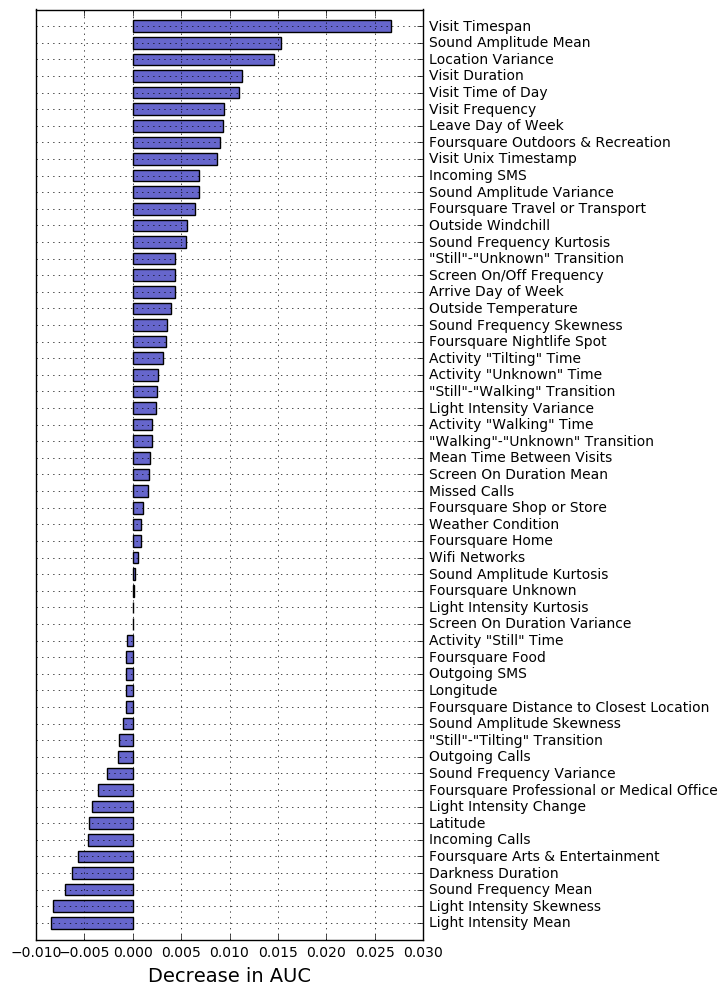

In [30]:
import matplotlib.pyplot as plt
import numpy as np

dic = {'lgt mean':'Light Intensity Mean', 'lgt std':'Light Intensity Variance', 'lgt off':'Darkness Duration', 'lgt zcrossing':'Light Intensity Change',\
       'lgt skew':'Light Intensity Skewness', 'lgt kurt':'Light Intensity Kurtosis', 'aud mean':'Sound Amplitude Mean', \
       'aud std':'Sound Amplitude Variance', 'aud skew':'Sound Amplitude Skewness', 'aud kurt':'Sound Amplitude Kurtosis',\
       'aud frq mean':'Sound Frequency Mean', 'aud frq std':'Sound Frequency Variance', 'aud frq skew':'Sound Frequency Skewness',\
       'aud frq kurt':'Sound Frequency Kurtosis', 'scr frq':'Screen On/Off Frequency', 'scr dur mean':'Screen On Duration Mean', \
       'scr dur std':'Screen On Duration Variance', 'still':'Activity "Still" Time', 'tilting':'Activity "Tilting" Time', 'walking':'Activity "Walking" Time',\
       'unknown act':'Activity "Unknown" Time', 'still-walking':'"Still"-"Walking" Transition', 'still-tilting':'"Still"-"Tilting" Transition',\
       'still-unknown':'"Still"-"Unknown" Transition', 'walking-unknown':'"Walking"-"Unknown" Transition', 'call in':'Incoming Calls', 'call out':\
       'Outgoing Calls', 'sms in':'Incoming SMS', 'sms out':'Outgoing SMS', 'call missed':'Missed Calls', 'n wifi':\
       'Wifi Networks', 'temperature':'Outside Temperature', 'dew point':'Outside Windchill', 'weather':'Weather Condition', \
       'lat mean':'Latitude', 'lng mean':'Longitude', 'loc var':'Location Variance', 'duration':'Visit Timespan',\
       'midtime':'Visit Unix Timestamp', 'midhour':'Visit Time of Day', 'dow start':'Arrive Day of Week', 'dow end':\
       'Leave Day of Week', 'fsq 0':'Foursquare Nightlife Spot', 'fsq 1':'Foursquare Outdoors & Recreation', 'fsq 2':'Foursquare Arts & Entertainment'\
       , 'fsq 3':'Foursquare Professional or Medical Office', 'fsq 4':'Foursquare Food', 'fsq 5':'Foursquare Home', \
       'fsq 6':'Foursquare Shop or Store', 'fsq 7':'Foursquare Travel or Transport', 'fsq 8':'Foursquare Unknown', 'fsq distance':\
       'Foursquare Distance to Closest Location', 'LT frequency':'Visit Frequency', 'LT interval mean':'Mean Time Between Visits', 'n gps':'Visit Duration'}

# extracting means and CIs
feature_label = feature_all[0].columns

# fscore_ci = np.array(fscore.std(axis=0)/np.sqrt(n_bootstrap))
ind_sort = np.array(np.argsort(delta_auc_mean))
delta_auc_mean_sorted = delta_auc_mean[ind_sort]
# ci_sorted = fscore_ci[ind_sort]
feature_label_sorted = feature_label[ind_sort]
feature_label_short = []
for i in range(feature_label_sorted.size):
    feature_label_short.append(dic[feature_label_sorted[i]])
    
%matplotlib inline
plt.figure(figsize=(5,12))
plt.barh(np.arange(delta_auc_mean_sorted.size), delta_auc_mean_sorted, height=.7, color=(.4,.4,.8), align='center', ecolor=(0,0,0))
plt.yticks(np.arange(len(feature_label_short)), feature_label_short, fontsize=10, color=(0,0,0))
# plt.box(on=False)
plt.xlabel('Decrease in AUC',fontsize=14)
plt.axes().yaxis.tick_right()
plt.ylim([-1, len(feature_label_short)])
plt.grid()